In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from tensorflow import keras
from tensorflow.keras import layers

This trainer is 'plug and play' as long as you have correct images and one-hot masks in the correct folders. However some hyperparameters should be modifed based on training hardware and dataset size. 

You also need to put the field identifier model in the models folder. 

# Image Generators

In [1]:
def batch_generator(agri_frames_path,nat_frames_path,masks_path,batch_size=4,img_size=(512,512),n_classes=6):
  while True:
    #Create our empty arrays for our images based on image size
    width, height = img_size


    #Create our zeros array for one-hot output. Based on img_size and classes. 
    

    '''Here we create our batch which is the first dimension in our array. We use enumurate to assign a value to each image we load in
    for so we can assign it the appropriate location in our batch. So we simply use the img-->array pipeline and assign that array to a spot in our batch array'''
    items_list = os.listdir(agri_frames_path)
    random.shuffle(items_list)
    start = 0
    end = batch_size
    while start < len(items_list):
      Xagri = np.empty((batch_size,width,height,3))
      Xnat = np.empty((batch_size,width,height,3))
      Y = np.zeros((batch_size,width,height,n_classes))
      for i, ID in enumerate(items_list[start:end]):
        # Build agri array
        Xagri[i,] = (keras.preprocessing.image.img_to_array(keras.preprocessing.image.load_img(agri_frames_path+ID,
                                                  target_size=img_size)))/255 #This divide by 255 is important
        #build nat array
        Xnat[i,] = (keras.preprocessing.image.img_to_array(keras.preprocessing.image.load_img(nat_frames_path+ID,
                                                  target_size=img_size)))/255
        #Build Y array
        Y[i,] = np.load(masks_path+ID[:-4]+'.npy')
      yield ([Xagri,Xnat],Y)
      start += batch_size
      end += batch_size

In [2]:
masks_path = 'images/one-hot-masks/'
agri_frames_path = 'images/agriframes/'
nat_frames_path = 'images/natframes/'
val_masks_path = 'images/validation/one-hot-masks/'
val_agri_path = 'images/validation/agriframes/'
val_nat_path = 'images/validation/natframes/'
batch_gen = batch_generator(agri_frames_path, nat_frames_path, masks_path)
val_gen = batch_generator(val_agri_path, val_nat_path, val_masks_path)

# Model

In [4]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

def base_model(agri_input_shape=(512,512,3),nat_input_shape=(512,512,3)):
  agri_input = Input(shape=agri_input_shape,dtype='float32',name='agri_input_base')
  nat_input = Input(shape=agri_input_shape,dtype='float32',name='nat_input_base')
  fields = tf.keras.models.load_model('models/field_model',compile=False)([agri_input, nat_input])
  x = Concatenate(axis=-1)([agri_input,nat_input,fields]) 
  x = Conv2D(16,(5,5),activation='relu',padding='same',data_format='channels_last',name='agr_block1_conv1')(x)
  x = Conv2D(16,(5,5),activation='relu',padding='same',data_format='channels_last',name='agr_block1_conv2')(x)
  x = MaxPool2D((3,3), strides=(1,1),padding='same')(x)
  x = Conv2D(16,(5,5),activation='relu',padding='same',data_format='channels_last',name='agr_block1_conv3')(x)
  x = Conv2D(16,(5,5),activation='relu',padding='same',data_format='channels_last',name='agr_block1_conv4')(x)
  bridge1 = x
  x = MaxPool2D((2,2),strides=(2,2))(x)  

  #Block 2
  x = Conv2D(32,(3,3),activation='relu',padding='same',data_format='channels_last',name='block2_conv1')(x)
  x = Conv2D(32,(3,3),activation='relu',padding='same',data_format='channels_last',name='block2_conv2')(x)
  bridge2 = x
  x = MaxPool2D((2,2), strides=(1,1),padding='same')(x)
  x = Conv2D(64,(3,3),activation='relu',padding='same',data_format='channels_last',name='block2_conv3')(x)
  x = Conv2D(64,(3,3),activation='relu',padding='same',data_format='channels_last',name='block2_conv4')(x)
  x = MaxPool2D((2,2),strides=(2,2))(x)

  #Block 3
  x = Conv2D(64,(3,3),activation='relu',padding='same',data_format='channels_last',name='block3_conv1')(x)
  x = Conv2D(64, (3,3),activation='relu',padding='same',data_format='channels_last',name='block3_conv2')(x)
  bridge3 = x
  x = MaxPool2D((2,2), strides=(1,1),padding='same')(x)
  x = Conv2D(128,(3,3),activation='relu',padding='same',data_format='channels_last',name='block3_conv3')(x)
  x = Conv2D(128, (3,3),activation='relu',padding='same',data_format='channels_last',name='block3_conv4')(x)
  x = MaxPool2D((2,2),strides=(2,2))(x)

  #Block 4
  x = Conv2D(128, (3,3),activation='relu',padding='same',data_format='channels_last',name='block4_conv1')(x)
  x = Conv2D(128, (3,3),activation='relu',padding='same',data_format='channels_last',name='block4_conv2')(x)
  bridge4 = x
  x = MaxPool2D((2,2),strides=(2,2))(x)
    
  #Block 5
  x = Conv2D(256, (3,3),activation='relu',padding='same',data_format='channels_last',name='block5_conv1')(x)
  x = Conv2D(256, (3,3),activation='relu',padding='same',data_format='channels_last',name='block5_conv2')(x)
  bridge5 = x
  x = MaxPool2D((2,2),strides=(2,2))(x)

  #Block 6
  x = Conv2D(512, (3,3),activation='relu',padding='same',data_format='channels_last',name='block6_conv1')(x)
  x = Conv2D(512, (3,3),activation='relu',padding='same',data_format='channels_last',name='block6_conv2')(x)
  x = UpSampling2D(size=(2, 2))(x)

  #Block 7
  x = Concatenate()([x,bridge5])
  x = Conv2D(512, (3,3),activation='relu',padding='same',data_format='channels_last',name='block7_conv1')(x)
  x = Conv2D(256, (3,3),activation='relu',padding='same',data_format='channels_last',name='block7_conv2')(x)
  x = MaxPool2D((2,2), strides=(1,1),padding='same')(x)
  x = Conv2D(256, (3,3),activation='relu',padding='same',data_format='channels_last',name='block7_conv3')(x)
  x = Conv2D(128, (3,3),activation='relu',padding='same',data_format='channels_last',name='block7_conv4')(x)
  x = UpSampling2D(size=(2, 2))(x)
    
  #Block 8
  x = Concatenate()([x,bridge4])
  x = Conv2D(128, (3,3),activation='relu',padding='same',data_format='channels_last',name='block8_conv1')(x)
  x = Conv2D(64, (3,3),activation='relu',padding='same',data_format='channels_last',name='block8_conv2')(x)
  x = UpSampling2D(size=(2, 2))(x)

  #Block 9
  x = Concatenate()([x,bridge3])
  x = Conv2D(64, (3,3),activation='relu',padding='same',data_format='channels_last',name='block9_conv1')(x)
  x = Conv2D(64, (3,3),activation='relu',padding='same',data_format='channels_last',name='block9_conv2')(x)
  x = UpSampling2D(size=(2, 2))(x)

  #Block 10
  x = Concatenate()([x,bridge2])
  x = Conv2D(64, (3,3),activation='relu',padding='same',data_format='channels_last',name='block10_conv1')(x)
  x = Conv2D(32, (3,3),activation='relu',padding='same',data_format='channels_last',name='block10_conv2')(x)
  x = UpSampling2D(size=(2, 2))(x)

  #Block 11
  x = concatenate([bridge1,x])
  x = Conv2D(32,(3,3),activation='relu',padding='same',data_format='channels_last',name='final_conv1')(x)
  x = Conv2D(128,(3,3),activation='relu',padding='same',data_format='channels_last',name='final_conv2')(x)
  x = Conv2D(128,(3,3),activation='relu',padding='same',data_format='channels_last',name='final_conv3')(x)
  x = Conv2D(6, (3, 3),activation='relu',padding='same',data_format='channels_last',name='final_classes')(x)
  x = Softmax()(x)
  

  model = Model([agri_input,nat_input], x)
  return model

In [5]:
model = base_model()
model.summary()

# Callbacks

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

checkpoint_path = 'checkpoint/'

checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', 
                             verbose=1, save_best_only=True,
                             save_weights_only=True)

early_stopping = EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                               patience = 2)

callbacks_list = [checkpoint,early_stopping]

In [7]:
'''
The weights must be calculated from masks. '''
weights = np.array([0.98,0.92,0.94,0.978,0.54,0.648])
from tensorflow.keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss
loss = weighted_categorical_crossentropy(weights)

In [8]:
#model.load_weights(checkpoint_path)
#Use the above line if resuming training
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0004), loss=loss,metrics=['accuracy'])


# Training

In [10]:
'''
    Assign the number of epochs and steps per epoch. I recommend samples/batch_size for your steps. 
    That way you run through every example in your folder.'''
epochs = 25
steps = 2048
results = model.fit(batch_gen, steps_per_epoch=steps, epochs=epochs,
                    validation_data=val_gen,
                    validation_steps=64,callbacks=callbacks_list)

Epoch 1/25
  32/2048 [..............................] - ETA: 17:50 - loss: 1.1181 - accuracy: 0.3572

KeyboardInterrupt: 

In [15]:
model.evaluate(val_gen,steps=64)

64/64 [==============================] - 19s 294ms/step - loss: 0.2768 - accuracy: 0.8488


[0.27677151560783386, 0.8487929105758667]

In [16]:
#Save the Model
model.trainable=False
model.save('models/classifier')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/Thesis\assets


# Prediction


In [18]:
color_list=[[204,78,134],
            [165,227,230],
            [255,255,85],
            [255,200,100],
            [0,0,0],
            [255,255,255]]
crops_list=['sugar beet',
            'barley',
            'maiz',
            'summer oat',
            'other',
            'background']
def predict_output(array,width=512,height=512):
  predict = np.empty((width,height,3))
  for i in range(width):
    for j in range(height):
      try:
        col_num = np.argmax(array[i,j])
        predict[i,j] = color_list[col_num]#np.multiply(color_list[col_num],array[i,j][col_num])
      except:
        predict[i,j] = [255,255,255]#np.multiply([255,255,255],array[i,j][int(col_num)])
  return predict.astype('int')

In [41]:
import random
pred_id = random.sample(os.listdir('images/validation/agriframes'),1)

agripredict = keras.preprocessing.image.img_to_array(keras.preprocessing.image.load_img(
                  'images/validation/agriframes/'+pred_id[0],
                                                  target_size=(512,512)))/255
natpredict = keras.preprocessing.image.img_to_array(keras.preprocessing.image.load_img(
                  'images/validation/natframes/'+pred_id[0],
                                                  target_size=(512,512)))/255

agripredict = agripredict[np.newaxis,...]
natpredict = natpredict[np.newaxis,...]

prediction = model.predict([agripredict,natpredict])

2017_74_mirror.png


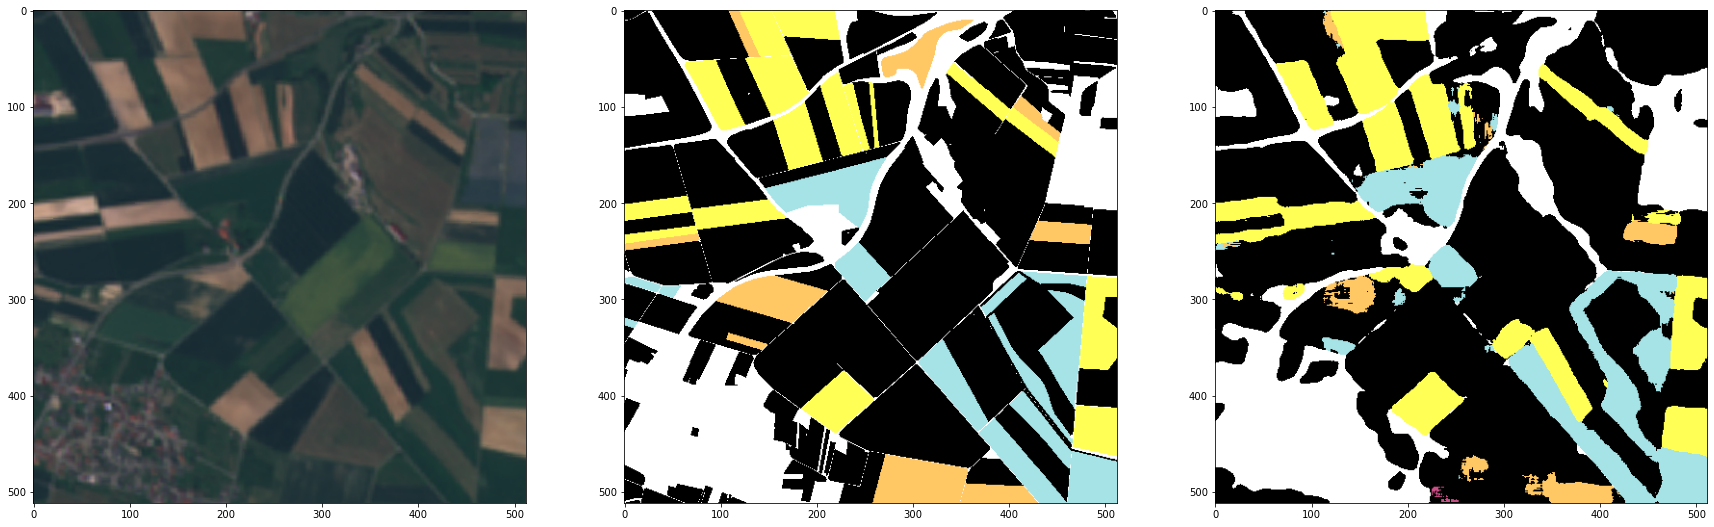

In [42]:
from PIL import Image
print(pred_id[0])
plt.figure(figsize=(30,10))
plt.subplot(131).imshow(Image.open('images/validation/natframes/'+pred_id[0]))
plt.subplot(133).imshow(predict_output(prediction[0]))
plt.subplot(132).imshow(predict_output(np.load('images/validation/one-hot-masks/'+pred_id[0][:-3]+'npy')))
